# Clasificación de sonido con Keras

## Dataset

Este conjunto de datos contiene los discursos de estos líderes prominentes; Benjamín Netanyahu, Jens Stoltenberg, Julia Gillard, Margaret
Tacher y Nelson Mandela que también representa los nombres de las carpetas. Cada audio de la carpeta es un PCM de un segundo de duración con una velocidad de muestreo de 16000 hz codificado.
Una carpeta llamada background_noise contiene audios que no son discursos, pero que se pueden encontrar en el interior alrededor del entorno del orador, por ejemplo, la audiencia riendo o aplaudiendo. Se puede mezclar con el discurso mientras se entrena.

### Referencias

https://www.kaggle.com/kongaevans/speaker-recognition-dataset/

## Enunciado

El objetivo del ejercicio consiste en utilizar un perceptrón multicapa para la identificación de la persona que se encuentra hablando a partir de un audio de un segundo de duración.

In [8]:
# Definimos un conjunto de constantes con las rutas de las carpetas que contienen los audios de cada persona
import os

DATASET_ROOT = r"C:\Users\santo\Desktop\Tiago\Portfolio\Curso Deep Learning\ClasificacionAudio\16000_pcm_speeches\16000_pcm_speeches"
BENJAMIN_DATA = os.path.join(DATASET_ROOT, "Benjamin_Netanyau")
JENS_DATA = os.path.join(DATASET_ROOT, "Jens_Stoltenberg")
JULIA_DATA = os.path.join(DATASET_ROOT, "Julia_Gillard")
MARGARET_DATA = os.path.join(DATASET_ROOT, "Magaret_Tarcher")
NELSON_DATA = os.path.join(DATASET_ROOT, "Nelson_Mandela")

## 1. Preparación del conjunto de datos

In [10]:
# Definimos una función para parsear nuestro conjunto de datos
import librosa
import numpy as np

def parse_dataset(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print("[+] Parsing {} data...".format(dataset))
        for fname in os.listdir(dataset):
            wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)
            D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
            X.append(D)
            y.append(index)
    return (X, y)

In [11]:
X, y = parse_dataset([BENJAMIN_DATA, JENS_DATA, JULIA_DATA, MARGARET_DATA, NELSON_DATA])

[+] Parsing C:\Users\santo\Desktop\Tiago\Portfolio\Curso Deep Learning\ClasificacionAudio\16000_pcm_speeches\16000_pcm_speeches\Benjamin_Netanyau data...
[+] Parsing C:\Users\santo\Desktop\Tiago\Portfolio\Curso Deep Learning\ClasificacionAudio\16000_pcm_speeches\16000_pcm_speeches\Jens_Stoltenberg data...
[+] Parsing C:\Users\santo\Desktop\Tiago\Portfolio\Curso Deep Learning\ClasificacionAudio\16000_pcm_speeches\16000_pcm_speeches\Julia_Gillard data...
[+] Parsing C:\Users\santo\Desktop\Tiago\Portfolio\Curso Deep Learning\ClasificacionAudio\16000_pcm_speeches\16000_pcm_speeches\Magaret_Tarcher data...
[+] Parsing C:\Users\santo\Desktop\Tiago\Portfolio\Curso Deep Learning\ClasificacionAudio\16000_pcm_speeches\16000_pcm_speeches\Nelson_Mandela data...


## 2. División del conjunto de datos

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [14]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [15]:
print("Longitud subconjunto de entrenamiento: ", len(X_train))
print("Longitud subconjunto de validación: ", len(X_val))
print("Longitud subconjunto de pruebas: ", len(X_test))

Longitud subconjunto de entrenamiento:  6750
Longitud subconjunto de validación:  376
Longitud subconjunto de pruebas:  375


## 3. Construcción del modelo

In [17]:
from tensorflow.keras.utils import to_categorical

def prep_dataset(X, y, shape):
    X_prep = np.array(X).reshape((len(X), shape))
    X_prep = X_prep.astype('float32') / 255
    y_prep = to_categorical(np.array(y))
    return (X_prep, y_prep)

In [18]:
X_train_prep, y_train_prep = prep_dataset(X_train, y_train, 1025*32)
X_val_prep, y_val_prep = prep_dataset(X_val, y_val, 1025*32)
X_test_prep, y_test_prep = prep_dataset(X_test, y_test, 1025*32)

In [19]:
X_train_prep

array([[-0.19455108, -0.12295566, -0.12199375, ..., -0.3137255 ,
        -0.2562542 , -0.21662043],
       [-0.12624805, -0.15379709, -0.20135677, ..., -0.31327748,
        -0.19976863, -0.16160354],
       [-0.08823299, -0.1131717 , -0.21725984, ..., -0.3137255 ,
        -0.3137255 , -0.3137255 ],
       ...,
       [-0.2144359 , -0.21245034, -0.15810075, ..., -0.3137255 ,
        -0.28764704, -0.2534157 ],
       [-0.13256176, -0.17139684, -0.18003492, ..., -0.3137255 ,
        -0.30897236, -0.27087495],
       [-0.14108275, -0.16493171, -0.28715748, ..., -0.3137255 ,
        -0.30382615, -0.28076333]], dtype=float32)

In [20]:
y_train_prep

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

### 3.1. Entrenamiento de una RNA sencilla

In [22]:
# Entrenamos un perceptrón multicapa
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')
clf.fit(X_train_prep, y_train)

C:\Users\santo\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')

In [23]:
# Realizamos la predicción con el conjunto de datos de validación
y_pred = clf.predict(X_val_prep)

In [24]:
# Mostramos el accuracy resultante de la clasificación
from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred)

0.9202127659574468

### 3.2. Entrenamiento de una RNA profunda

In [26]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [27]:
network = models.Sequential()

network.add(layers.Dense(300, activation='relu', input_shape=(1025*32,)))
network.add(layers.Dense(200, activation='relu'))
network.add(layers.Dense(100, activation='relu'))
network.add(layers.Dense(5, activation='softmax'))

C:\Users\santo\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
network.compile(loss='categorical_crossentropy',
                optimizer='sgd',
                metrics=['accuracy', 'Precision'])

In [29]:
history = network.fit(X_train_prep, 
                      y_train_prep,
                      epochs=30,
                      validation_data=(X_val_prep, y_val_prep))

Epoch 1/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - Precision: 0.6246 - accuracy: 0.3381 - loss: 1.4869 - val_Precision: 0.8785 - val_accuracy: 0.5771 - val_loss: 1.0850
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - Precision: 0.7196 - accuracy: 0.5469 - loss: 1.0870 - val_Precision: 0.8388 - val_accuracy: 0.6649 - val_loss: 0.9248
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - Precision: 0.7784 - accuracy: 0.6558 - loss: 0.8667 - val_Precision: 0.8442 - val_accuracy: 0.6835 - val_loss: 0.7746
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - Precision: 0.8019 - accuracy: 0.7179 - loss: 0.7284 - val_Precision: 0.8964 - val_accuracy: 0.7819 - val_loss: 0.5806
Epoch 5/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - Precision: 0.8262 - accuracy: 0.7787 - loss: 0.6169 - val_Precision: 0.7560 - val_accuracy: 0.7394 - val_loss: 0.5828
Epoch 6/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - Precision: 0.8428 - accuracy: 0.7972 - loss: 0.5403 - val_Precision: 0.9137 - va

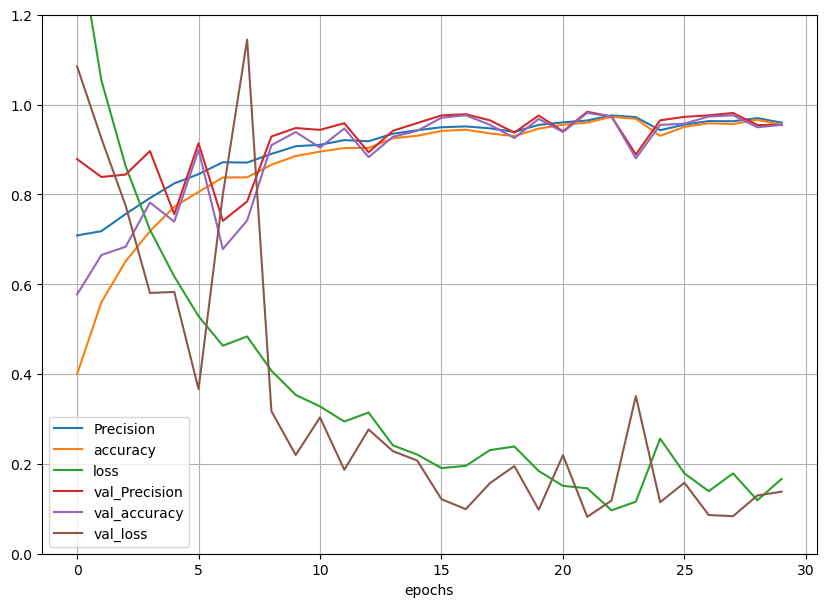

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.xlabel("epochs")
plt.show()

### 3.3. Predicción para nuevos ejemplos

In [32]:
# Realizamos la predicción para el subconjunto de pruebas
test_loss, test_acc, test_prec = network.evaluate(X_test_prep, y_test_prep)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.9653 - accuracy: 0.9653 - loss: 0.1139 


In [33]:
print('test_acc:', test_acc)
print('test_prec:', test_prec)

test_acc: 0.9599999785423279
test_prec: 0.9599999785423279
